# Import and settings

In [8]:
pip install plotnine

Note: you may need to restart the kernel to use updated packages.


In [9]:
%load_ext autoreload
%autoreload 2

from time import localtime, strftime
import os, re, gc, joblib
import numpy as np
import numpy_groupies as npg
import pandas as pd

import anndata
import scanpy as sc
import sctk as sk

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import seaborn as sn
import plotnine as pln

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
np.set_printoptions(linewidth=150)

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42

sc.settings.verbosity = 0
expr_cmap = sk.expression_colormap()
sk.set_figsize((4, 4))

In [11]:
def timestamp(date_only=True):
    stamp_format = "%Y%m%d" if date_only else "%Y%m%d-%H%M"
    return strftime(stamp_format, localtime())

In [12]:
def get_reaction_consistencies(compass_reaction_penalties, min_range=1e-3):
    """
    Converts the raw penalties outputs of compass into scores per reactions where higher numbers indicate more activity
    """
    df = -np.log(compass_reaction_penalties + 1)
    df = df[df.max(axis=1) - df.min(axis=1) >= min_range]
    df = df - df.min().min()
    return df

# Load data

In [13]:
reaction_metadata = pd.read_csv("/home/jovyan/COMPASSResources/reaction_metadata.csv", index_col=0)

In [14]:
reaction_metadata.head()

,reaction_name,formula,associated_genes,subsystem,EC_number,confidence
reaction_no_direction,,,,,,
10FTHF5GLUtl,"5-glutamyl-10FTHF transport, lysosomal",1.00 * 10-formyltetrahydrofolate-[Glu](5) [c] ...,NaN,"Transport, lysosomal",NaN,2.0
10FTHF5GLUtm,"5-glutamyl-10FTHF transport, mitochondrial",1.00 * 10-formyltetrahydrofolate-[Glu](5) [m] ...,NaN,"Transport, mitochondrial",NaN,2.0
10FTHF6GLUtl,"6-glutamyl-10FTHF transport, lysosomal",1.00 * 10-formyltetrahydrofolate-[Glu](6) [c] ...,NaN,"Transport, lysosomal",NaN,2.0
10FTHF6GLUtm,"6-glutamyl-10FTHF transport, mitochondrial",1.00 * 10-formyltetrahydrofolate-[Glu](6) [m] ...,NaN,"Transport, mitochondrial",NaN,2.0
10FTHF7GLUtl,"7-glutamyl-10FTHF transport, lysosomal",1.00 * 10-formyltetrahydrofolate-[Glu](7) [c] ...,NaN,"Transport, lysosomal",NaN,2.0


In [15]:
vcm_types = ['VentricularCardiomyocytesPRRX1pos', 'VentricularCardiomyocytesCycling', 'VentricularCardiomyocytesCompact', 'VentricularCardiomyocytesTrabeculated', 'VentricularConductionSystemDistal', 'VentricularConductionSystemProximal']

The numbers in the reactions tsv correspond to penalties for each reaction per cell, so we take the negative log to get scores that are higher the more active the reaction is predicted to be. This also drops reactions that are close to constant and therefore not informative for the comparison.

In [9]:
cell_metadata = pd.concat(
    [pd.read_csv(f"{metadata_dir}/{t}_metadata.csv", index_col=0) for t in t_types]
)

In [10]:
cell_metadata.shape

(2680, 19)

In [12]:
pooled_ad = anndata.AnnData(
    get_reaction_consistencies(pd.read_csv(f"{compass_dir}/reactions.tsv", sep="\t", index_col=0)).T
)

In [13]:
pooled_ad.obs = pooled_ad.obs.merge(cell_metadata, how="left", left_index=True, right_index=True)

In [14]:
pooled_ad

AnnData object with n_obs × n_vars = 2680 × 6493
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rps', 'percent.rpl', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'cluster_id', 'group_donor', 'DonorID', 'PatientGroup', 'celltype'

In [15]:
pooled_ad.obs["amanda_annot"] = sk.regroup(
    pooled_ad,
    groupby="celltype",
    regroups={
        "EMRA_CTL": "EMRA/cytolytic",
        "Naive_TCM": "Naive/TCM",
        "TMC_TEM": "TMC/TEM",
        "TMC_TRMint": "TMC-TRM_int",
        "TRM": "TRM",
        "Treg": "Treg",
    },
)

In [16]:
pooled_ad.var = pooled_ad.var.merge(
    reaction_metadata, how="left", left_index=True, right_index=True
)

In [17]:
pooled_ad

AnnData object with n_obs × n_vars = 2680 × 6493
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rps', 'percent.rpl', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'cluster_id', 'group_donor', 'DonorID', 'PatientGroup', 'celltype', 'amanda_annot'
    var: 'reaction_name', 'formula', 'associated_genes', 'subsystem', 'EC_number', 'confidence'

In [18]:
today = timestamp()
print(today)

20220620


In [19]:
pooled_ad.write(f"asthma_metabolome.compass.converted_in_pool.{today}.h5ad", compression="lzf")

... storing 'orig.ident' as categorical
... storing 'Phase' as categorical
... storing 'old.ident' as categorical
... storing 'group_donor' as categorical
... storing 'DonorID' as categorical
... storing 'PatientGroup' as categorical
... storing 'celltype' as categorical
... storing 'reaction_name' as categorical
... storing 'formula' as categorical
... storing 'associated_genes' as categorical
... storing 'subsystem' as categorical
... storing 'EC_number' as categorical


# Process

In [38]:
today = timestamp()

In [28]:
pooled_ad = sc.read(f"asthma_metabolome.compass.converted_in_pool.{today}.h5ad")

In [20]:
pooled_ad0 = pooled_ad.copy()

## QC

In [21]:
sk.calculate_qc(pooled_ad0, flags={})

In [22]:
pooled_ad0

AnnData object with n_obs × n_vars = 2680 × 6493
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rps', 'percent.rpl', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'cluster_id', 'group_donor', 'DonorID', 'PatientGroup', 'celltype', 'amanda_annot', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_top50'
    var: 'reaction_name', 'formula', 'associated_genes', 'subsystem', 'EC_number', 'confidence', 'n_counts', 'n_cells'

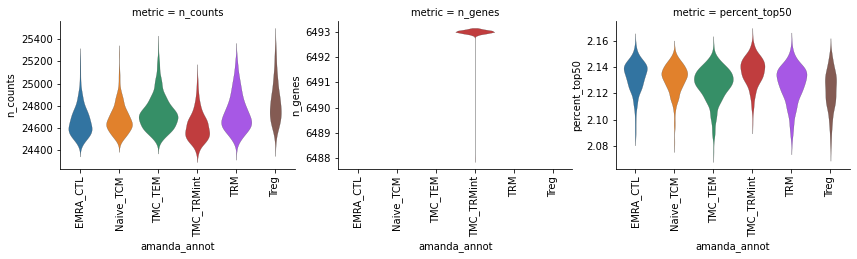

In [23]:
sk.plot_qc_violin(
    pooled_ad0,
    groupby="amanda_annot",
    metrics=["n_counts", "n_genes", "percent_top50"],
    rotation=90,
)

Distribution seems very different from nUMI

Let's take a closer look

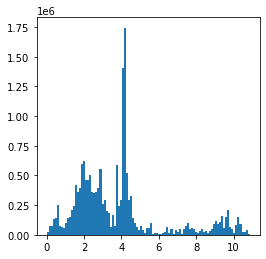

In [24]:
plt.hist(pooled_ad0.X.flatten(), 100);

Distribution very multi-modal

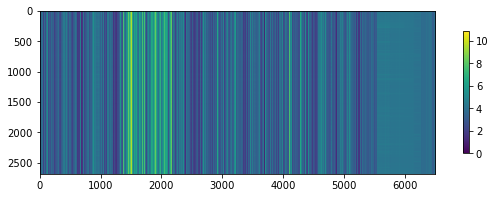

In [25]:
sk.set_figsize((10, 3))
plt.imshow(pooled_ad0.X)
plt.colorbar(shrink=0.75);

## Including TRM

### normalisation before log1p

In [27]:
pooled_ad1 = pooled_ad0.copy()

In [28]:
sc.pp.normalize_total(pooled_ad1, target_sum=1e4)
sc.pp.log1p(pooled_ad1)
pooled_ad1.raw = pooled_ad1

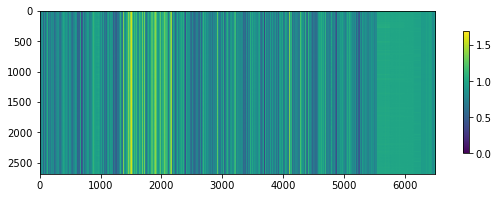

In [29]:
sk.set_figsize((10, 3))
plt.imshow(pooled_ad1.X)
plt.colorbar(shrink=0.75);

In [30]:
pooled_ad1.raw.X.sum(axis=1).min(), pooled_ad1.raw.X.sum(axis=1).max()

(5627.372, 5657.59)

In [31]:
sc.pp.highly_variable_genes(pooled_ad1, subset=False)

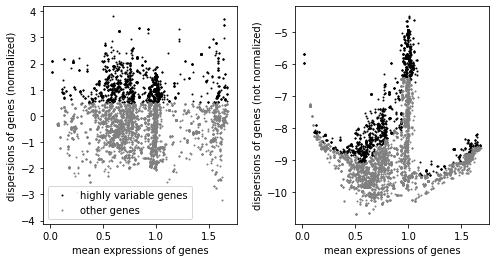

In [32]:
sk.set_figsize((4, 4))
sc.pl.highly_variable_genes(pooled_ad1)

In [33]:
sc.pp.scale(pooled_ad1, zero_center=True, max_value=10)

#### highly variable features only

In [55]:
pooled_ad1a = pooled_ad1.copy()
sc.pp.pca(pooled_ad1a, use_highly_variable=True)
sc.pp.neighbors(pooled_ad1a, n_neighbors=10, n_pcs=14)
sc.tl.umap(pooled_ad1a, min_dist=0.1)

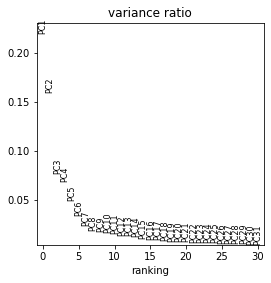

In [56]:
sc.pl.pca_variance_ratio(pooled_ad1a)

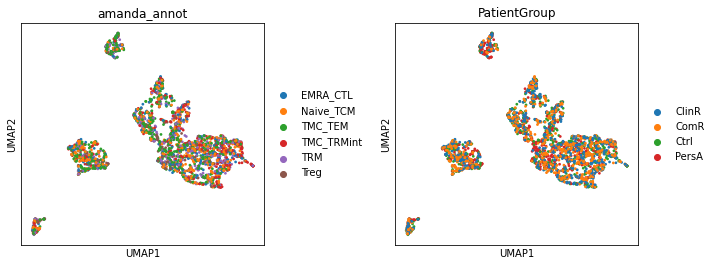

In [57]:
sc.pl.umap(pooled_ad1a, color=["amanda_annot", "PatientGroup"], wspace=0.4, size=30)

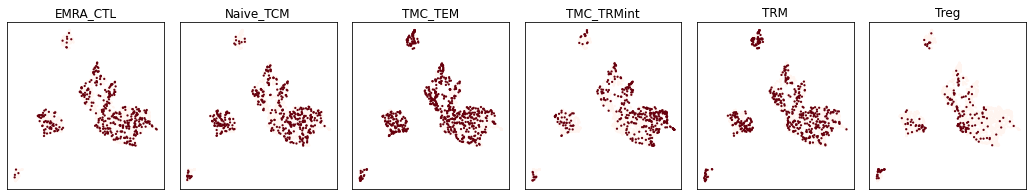

In [58]:
sk.highlight(
    pooled_ad1a, basis="umap", groupby="amanda_annot", wspace=0, figsize=(3, 3), size=20, ncols=6
)

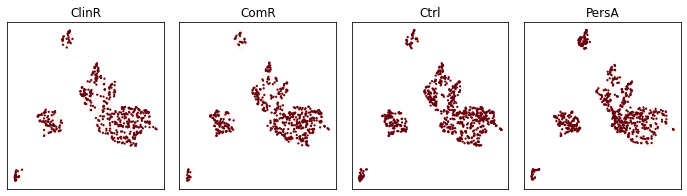

In [59]:
sk.highlight(
    pooled_ad1a, basis="umap", groupby="PatientGroup", wspace=0, figsize=(3, 3), size=20, ncols=6
)

In [60]:
sc.tl.leiden(pooled_ad1a, resolution=0.3, key_added="leiden_0p3")

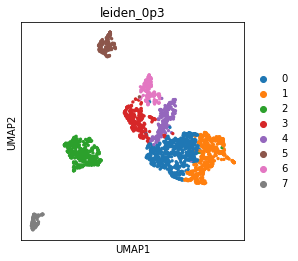

In [61]:
sk.set_figsize((4, 4))
sc.pl.umap(pooled_ad1a, color=["leiden_0p3"])

In [62]:
sc.tl.rank_genes_groups(pooled_ad1a, groupby="leiden_0p3", method="wilcoxon")

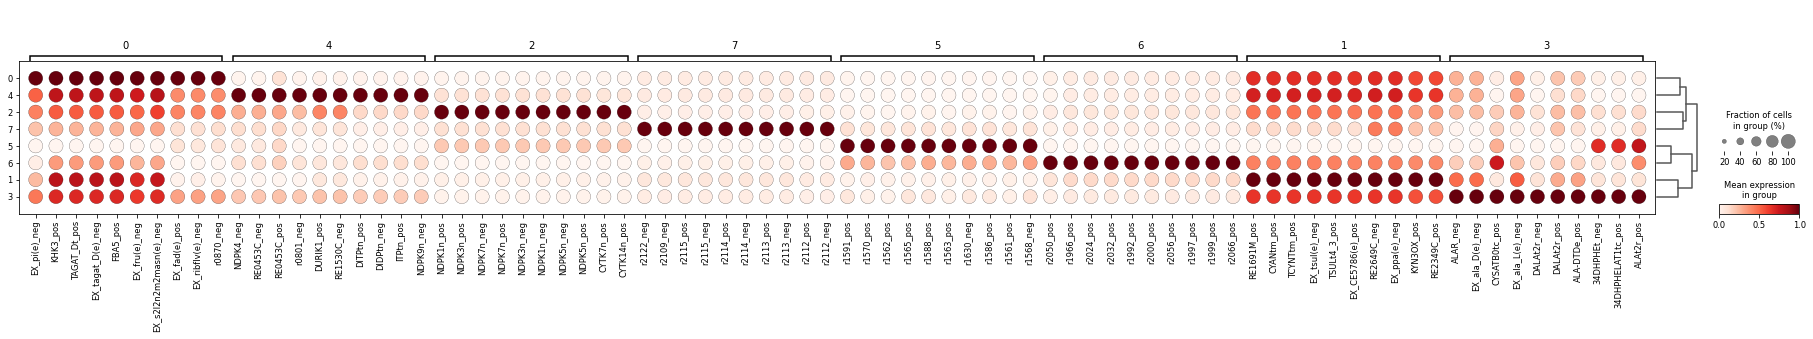

In [63]:
sc.pl.rank_genes_groups_dotplot(pooled_ad1a, groupby="leiden_0p3", standard_scale="var")

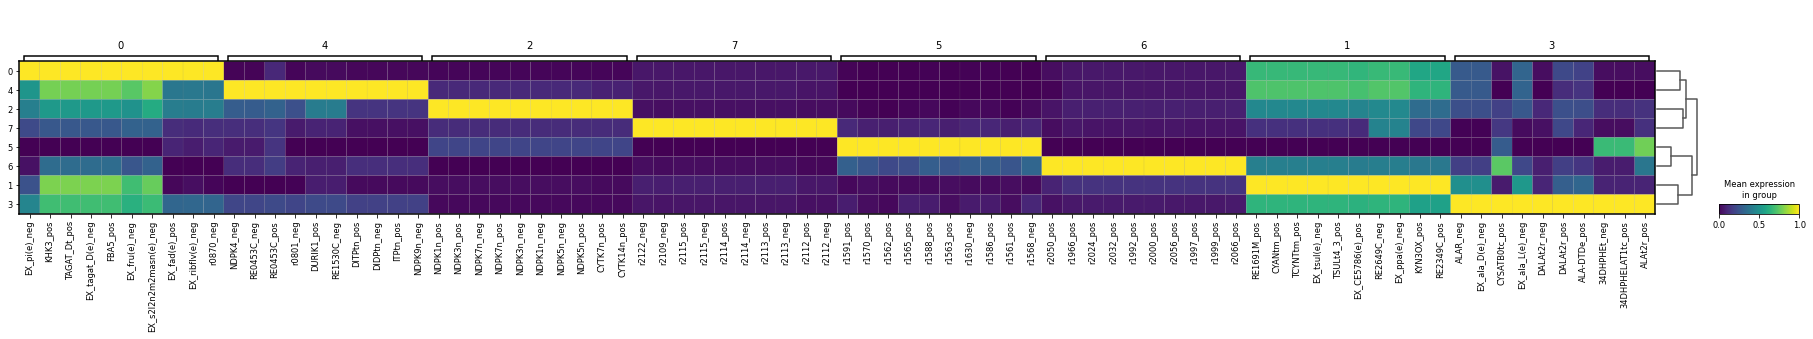

In [64]:
sc.pl.rank_genes_groups_matrixplot(pooled_ad1a, groupby="leiden_0p3", standard_scale="var")

#### all features

In [71]:
pooled_ad1b = pooled_ad1.copy()
sc.pp.pca(pooled_ad1b, use_highly_variable=False)
sc.pp.neighbors(pooled_ad1b, n_neighbors=20, n_pcs=10)
sc.tl.umap(pooled_ad1b, min_dist=0.1)

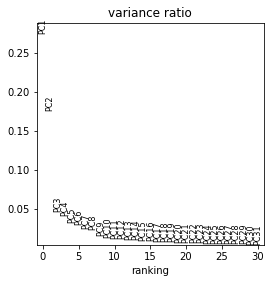

In [69]:
sc.pl.pca_variance_ratio(pooled_ad1b)

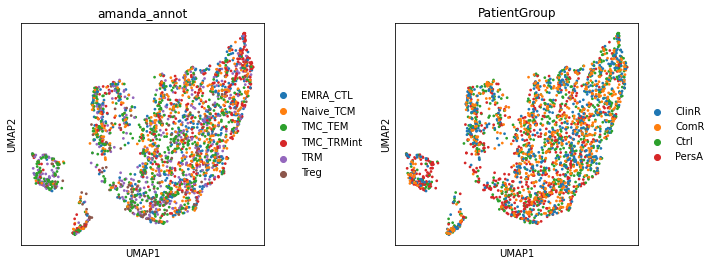

In [72]:
sc.pl.umap(pooled_ad1b, color=["amanda_annot", "PatientGroup"], wspace=0.4, size=30)

In [47]:
pooled_ad1b.obs.dtypes

orig.ident         category
nCount_RNA            int64
nFeature_RNA          int64
percent.mt          float64
percent.rps         float64
percent.rpl         float64
S.Score             float64
G2M.Score           float64
Phase              category
old.ident          category
nCount_SCT          float64
nFeature_SCT          int64
SCT_snn_res.0.8       int64
seurat_clusters       int64
cluster_id            int64
group_donor        category
DonorID            category
PatientGroup       category
celltype           category
amanda_annot       category
n_counts            float32
log1p_n_counts      float32
n_genes               int64
log1p_n_genes       float64
percent_top50       float64
dtype: object

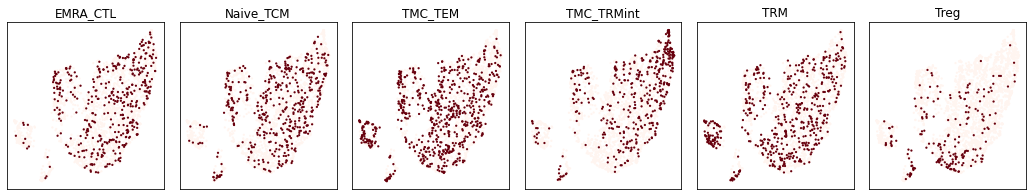

In [73]:
sk.highlight(
    pooled_ad1b, basis="umap", groupby="amanda_annot", wspace=0, figsize=(3, 3), size=20, ncols=6
)

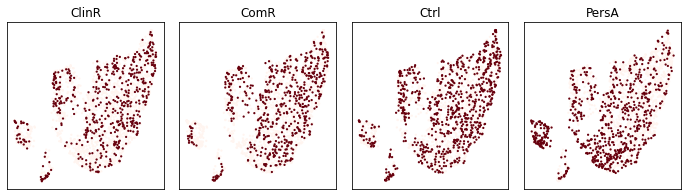

In [74]:
sk.highlight(
    pooled_ad1b, basis="umap", groupby="PatientGroup", wspace=0, figsize=(3, 3), size=20, ncols=6
)

In [75]:
sc.tl.leiden(pooled_ad1b, resolution=0.3, key_added="leiden_0p3")

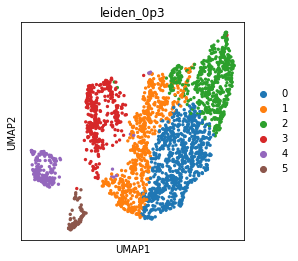

In [76]:
sk.set_figsize((4, 4))
sc.pl.umap(pooled_ad1b, color=["leiden_0p3"])

In [77]:
sc.tl.rank_genes_groups(pooled_ad1b, groupby="leiden_0p3", method="wilcoxon")

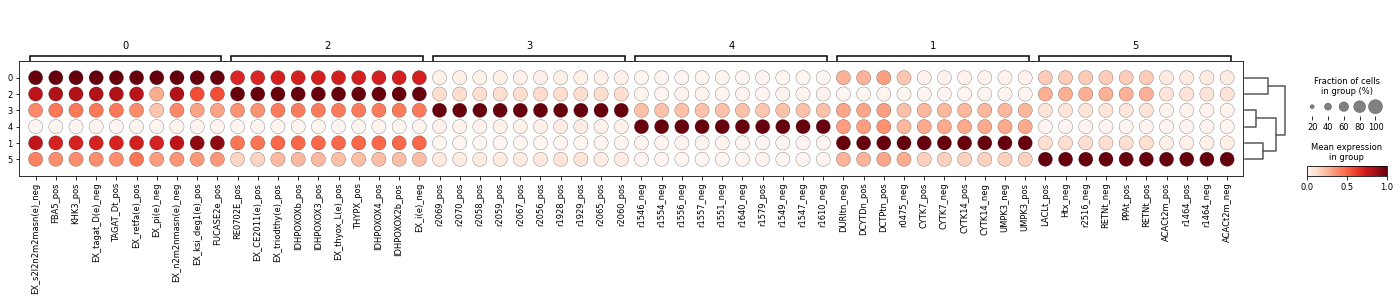

In [78]:
sc.pl.rank_genes_groups_dotplot(pooled_ad1b, groupby="leiden_0p3", standard_scale="var")

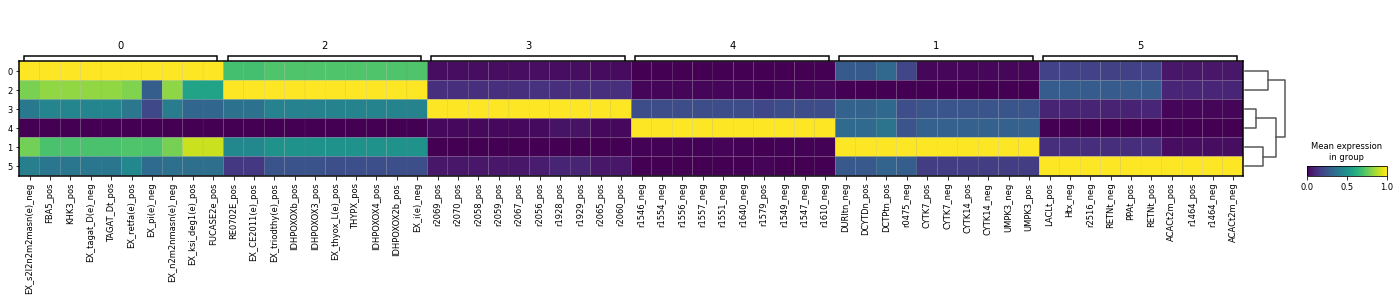

In [79]:
sc.pl.rank_genes_groups_matrixplot(pooled_ad1b, groupby="leiden_0p3", standard_scale="var")

# Save object

In [83]:
pooled_ad1a

AnnData object with n_obs × n_vars = 2680 × 6493
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rps', 'percent.rpl', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'cluster_id', 'group_donor', 'DonorID', 'PatientGroup', 'celltype', 'amanda_annot', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_top50', 'leiden_0p3'
    var: 'reaction_name', 'formula', 'associated_genes', 'subsystem', 'EC_number', 'confidence', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_0p3_colors', 'rank_genes_groups', 'dendrogram_leiden_0p3'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [85]:
pooled_ad1a.write("asthma_metabolome.compass.converted_in_pool.hvg_umap.20220620.h5ad", compression="gzip")

In [84]:
pooled_ad1b

AnnData object with n_obs × n_vars = 2680 × 6493
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rps', 'percent.rpl', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'cluster_id', 'group_donor', 'DonorID', 'PatientGroup', 'celltype', 'amanda_annot', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_top50', 'leiden_0p3'
    var: 'reaction_name', 'formula', 'associated_genes', 'subsystem', 'EC_number', 'confidence', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_0p3_colors', 'rank_genes_groups', 'dendrogram_leiden_0p3'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [86]:
pooled_ad1b.write("asthma_metabolome.compass.converted_in_pool.all_umap.20220620.h5ad", compression="gzip")